Copyright (c) 2017, Johannes Schöneberg. All rights reserved.
The default copyright laws apply.

In [1]:
import csv


#http://soft-matter.github.io/trackpy/v0.3.2/tutorial/walkthrough.html


from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
#mpl.rc('figure',  figsize=(10, 6))
#mpl.rc('image', cmap='gray')

import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp

import scipy


import math

from scipy import optimize

import scipy.ndimage

from pylab import *
from scipy.optimize import curve_fit

from numpy import genfromtxt

In [2]:
# this function puts zeros in all positions after the scission event
def cleanTraceAfterScission(trace,breakFrameId):
    newTrace = []
    for i in range(0,len(trace)):
        if(i>=breakFrameId):
            newTrace.append(0)
        else:
            newTrace.append(trace[i])
    return newTrace

In [3]:
## OUTPUT
def writeOutputToFile(filename,output_data,header):
    with open(filename,'wb') as f:
        np.savetxt(f, 
           output_data, 
           delimiter=',',
           fmt='%10.5f',
           header=header) 

In [4]:
time_UV = 150 #seconds after the force file was created
breakFrameId = 516
nFramesMovie = 700
pixelsPerMicron = 7.8363

filterWindowSize = 50

secondsPerFrame = 0.3744 #s/frame
forceFileLeadTime = 54 #seconds that the ff was started earlier than the movie

xlimit = (-180,220)

#https://stackoverflow.com/questions/22408237/named-colors-in-matplotlib
c_ch1 = 'aqua'
c_ch1 = 'deepskyblue'
c_ch1 = 'cyan'

c_ch2 = 'springgreen'
c_ch2 = 'lime'
c_ch3 = 'red'
lwidth = 3



# Channel 3 (membrane)

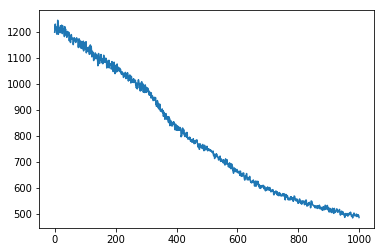

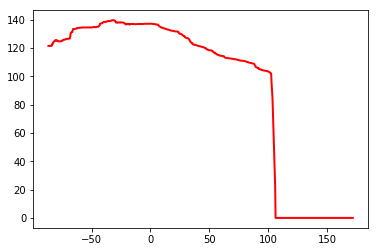

In [5]:

my_data = np.array(genfromtxt('./input/vesicle_tube_UV_movie__ch3_flPerFrame.csv', delimiter=','))
plt.plot(my_data[:,0],my_data[:,1],'-')
plt.show()

tube_intensity = genfromtxt('out_tube_fluorescenceIntensity.csv', delimiter=',')
plt.plot(tube_intensity[:,0],tube_intensity[:,3],c=c_ch3,lw=2)
plt.show()


# calculate the time of the movie, normalized on the start of the force file



time = 1+np.arange(0,nFramesMovie)

timeShiftDueDoWalkAvg = nFramesMovie -len(tube_intensity[:,3])
#print(forceFileLeadTime+secondsPerFrame*time+timeShiftDueDoWalkAvg)
time = forceFileLeadTime+secondsPerFrame*time+timeShiftDueDoWalkAvg





In [6]:
# calculate the time of the movie, normalized on the start of the force file


print(len(my_data))
time_vesicle = 1+np.arange(0,len(my_data[:,1]))



#timeShiftDueDoWalkAvg = time_vesicle -nFramesMovie


#time_vesicle = forceFileLeadTime+secondsPerFrame*time_vesicle+timeShiftDueDoWalkAvg

time_vesicle = secondsPerFrame*time_vesicle
print(time_vesicle)
print(secondsPerFrame)
print(1+np.arange(0,len(my_data[:,1]))*0.3744)

1001
[  3.74400000e-01   7.48800000e-01   1.12320000e+00 ...,   3.74025600e+02
   3.74400000e+02   3.74774400e+02]
0.3744
[   1.        1.3744    1.7488 ...,  374.6512  375.0256  375.4   ]


In [7]:
def expdecay(x, a, c, d):
    return a*np.exp(-c*x)+d

[  1.32609684e+03   2.51080619e-03  -6.64948133e+01]


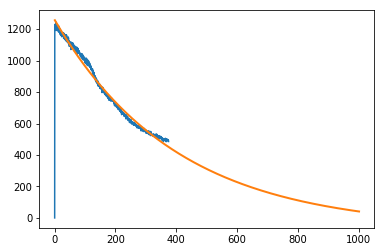

In [8]:
x = time_vesicle
y = np.nan_to_num(my_data[:,1])

popt, pcov = curve_fit(expdecay, x, y, p0=( y[0],1e-2,1))
print(popt)

# np.linspace(start, stop, number of samples)
xx = np.linspace(1, len(x), len(x))

yy = expdecay(xx, *popt)


plt.plot(x, y, '-')
plt.plot(xx, yy,lw=2)



# correct vesicle Fluorescence

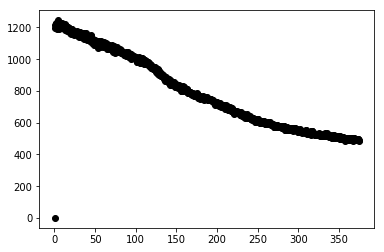

[  1.32609684e+03   2.51080619e-03  -6.64948133e+01]


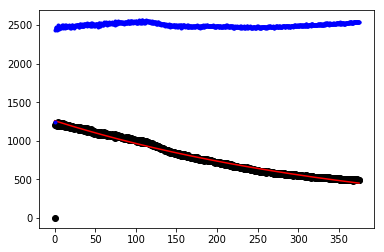

In [9]:
xt = time_vesicle
yt = y
plt.plot(xt, yt, 'ko')
plt.show()

#popt, pcov = curve_fit(func, x, y, p0=(1, 1e-3, 1))
print(popt)

# np.linspace(start, stop, number of samples)
xxt = np.linspace(0, xt[-1], len(xt))

# the equation is: 
# (initial value, decay rate, background) 
# from the first value of the plot, get N0+background = 17 in our case
# from the value after the tube broke, get the background = 5
# get the decay rate from the fit of the bare membrane 
# arrive at the parameters for the equation:
# popt = [  12 ,  8.87239023e-3 ,  5]
y0 = 2500
yyt = expdecay(xxt, *popt)

plt.plot(xt, yt, 'ko')

plt.plot(xxt, yyt,'r')

plt.plot(xt,y0+yt-yyt,'b.')


finalx = xt[1:-1]
finaly = (y0+yt-yyt)[1:-1]



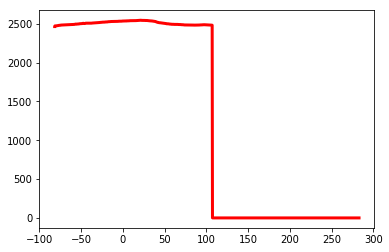

In [10]:
finalxClean = finalx - time_UV + forceFileLeadTime + timeShiftDueDoWalkAvg
finalyClean= cleanTraceAfterScission(finaly,breakFrameId)
plt.plot(scipy.ndimage.median_filter(finalxClean,size=50),
         scipy.ndimage.median_filter(finalyClean,size=50),c=c_ch3,lw=3)

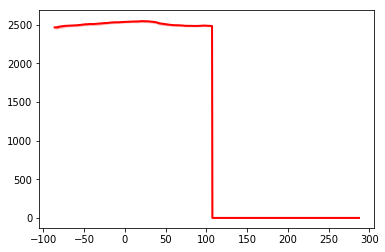

In [11]:
#calculate the standard deviation for the trace

mean = scipy.ndimage.median_filter(finalyClean,size=50)
std = scipy.ndimage.generic_filter(finaly,np.std,size=50)
for i in range(0,len(mean)):
    if(mean[i]==0):
        std[i]=0
    else:
        std[i]=std[i]/mean[i]
plt.plot(finalxClean,mean,c=c_ch3,lw=2)
#plt.plot(tube_intensity[:,0],std,c='blue',lw=2)
plt.fill_between(finalxClean,mean-1*std*mean, mean+1*std*mean, color=c_ch3, alpha=0.2)
plt.show()


#img_std = ndimage.filters.generic_filter(img, np.std, size=subs)

In [12]:
# output corrected intensity File
output_data_intensity = np.transpose(np.asarray((finalxClean,mean,std)))

writeOutputToFile("./output/out_vesicle_fluorescenceIntensity_ch3_corrected.csv",output_data_intensity,header="time[s], intensity[AU], normalized std")


# correct tube fluorescence

691
[   0.3744    0.7488    1.1232    1.4976    1.872     2.2464    2.6208
    2.9952    3.3696    3.744     4.1184    4.4928    4.8672    5.2416
    5.616     5.9904    6.3648    6.7392    7.1136    7.488     7.8624
    8.2368    8.6112    8.9856    9.36      9.7344   10.1088   10.4832
   10.8576   11.232    11.6064   11.9808   12.3552   12.7296   13.104
   13.4784   13.8528   14.2272   14.6016   14.976    15.3504   15.7248
   16.0992   16.4736   16.848    17.2224   17.5968   17.9712   18.3456
   18.72     19.0944   19.4688   19.8432   20.2176   20.592    20.9664
   21.3408   21.7152   22.0896   22.464    22.8384   23.2128   23.5872
   23.9616   24.336    24.7104   25.0848   25.4592   25.8336   26.208
   26.5824   26.9568   27.3312   27.7056   28.08     28.4544   28.8288
   29.2032   29.5776   29.952    30.3264   30.7008   31.0752   31.4496
   31.824    32.1984   32.5728   32.9472   33.3216   33.696    34.0704
   34.4448   34.8192   35.1936   35.568    35.9424   36.3168   36.6912
   3

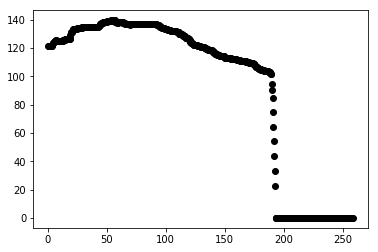

[  1.32609684e+03   2.51080619e-03  -6.64948133e+01]


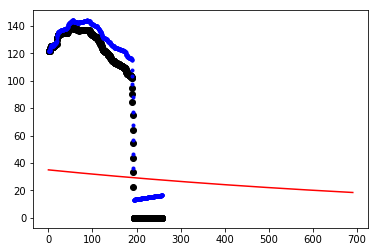

In [13]:

yt = tube_intensity[:,3]


####
print(len(yt))
time = 1+np.arange(0,len(yt))



timeShiftDueDoWalkAvg = len(time) -nFramesMovie


#time_vesicle = forceFileLeadTime+secondsPerFrame*time_vesicle+timeShiftDueDoWalkAvg

time = secondsPerFrame*time
print(time)
xt = time
print(len(xt))
####


plt.plot(xt, yt, 'ko')
plt.show()

#popt, pcov = curve_fit(func, x, y, p0=(1, 1e-3, 1))
print(popt)

# np.linspace(start, stop, number of samples)
xxt = np.linspace(0, len(xt), len(xt))

# the equation is: 
# (initial value, decay rate, background) 
# from the first value of the plot, get N0+background = 17 in our case
# from the value after the tube broke, get the background = 5
# get the decay rate from the fit of the bare membrane 
# arrive at the parameters for the equation:
# popt = [  12 ,  8.87239023e-3 ,  5]
y0 = 35
popt = [  y0   ,9.20756420e-04 , 0]
yyt = expdecay(xxt, *popt)

plt.plot(xt, yt, 'ko')

plt.plot(xxt, yyt,'r')

plt.plot(xt,y0+yt-yyt,'b.')


finalx = xt
finaly = y0+yt-yyt


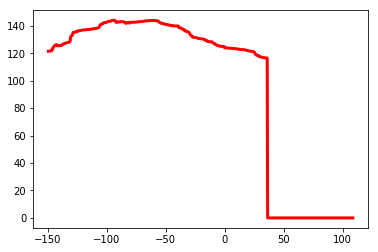

In [14]:
finalxClean = finalx - time_UV
finalyClean= cleanTraceAfterScission(finaly,breakFrameId-19)
plt.plot(scipy.ndimage.median_filter(finalxClean,size=1),
         scipy.ndimage.median_filter(finalyClean,size=1),c=c_ch3,lw=3)

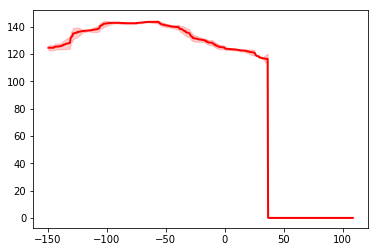

In [15]:
#calculate the standard deviation for the trace

mean = scipy.ndimage.median_filter(finalyClean,size=50)
std = scipy.ndimage.generic_filter(finaly,np.std,size=50)
for i in range(0,len(mean)):
    if(mean[i]==0):
        std[i]=0
    else:
        std[i]=std[i]/mean[i]
        
# remove the artificial spike in standard deviation due to the cut        
for i in range(0,len(mean)-50):
    if(std[i+30]==0):
        std[i]=0.1*std[i]
        
        
plt.plot(finalxClean,mean,c=c_ch3,lw=2)
#plt.plot(tube_intensity[:,0],std,c='blue',lw=2)
plt.fill_between(finalxClean,mean-1*std*mean, mean+1*std*mean, color=c_ch3, alpha=0.2)
plt.show()


#img_std = ndimage.filters.generic_filter(img, np.std, size=subs)

In [16]:
# output corrected intensity File
output_data_intensity = np.transpose(np.asarray((finalxClean,mean,std)))

writeOutputToFile("./output/out_tube_fluorescenceIntensity_ch3_corrected.csv",output_data_intensity,header="time[s], max intensity ch3[AU]")


# Channel 2

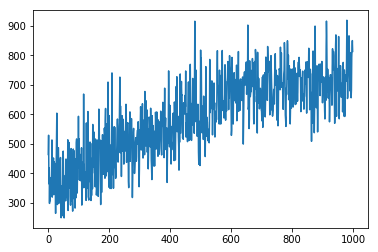

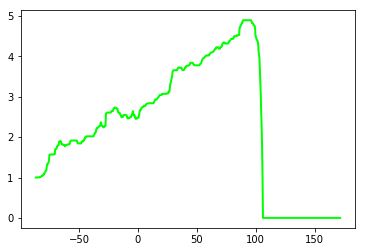

In [17]:
from numpy import genfromtxt
my_data = np.array(genfromtxt('./input/vesicle_tube_UV_movie__ch2_flPerFrame.csv', delimiter=','))
plt.plot(my_data[:,0],my_data[:,1],'-')
plt.show()

tube_intensity = genfromtxt('./output/out_tube_fluorescenceIntensity.csv', delimiter=',')
plt.plot(tube_intensity[:,0],tube_intensity[:,2]/tube_intensity[:,2][0],c=c_ch2,lw=2)
plt.show()

rescale back 1: + -150.0 - 0.0
rescale back 2: * 1000.0 - 0.0
rescale back 1: + 0.0 - 0.0
rescale back 2: * 919.555 - 0.0
[ 0.     0.001  0.002 ...,  0.998  0.999  1.   ]
[ 0.          0.50437549  0.57542072 ...,  0.89683379  0.92489084
  0.88501395]
x0 = 0.29095999532257477
y0 = 0.3055952125977694
c = 0.4997013064188255
k = 4.7704203633349165



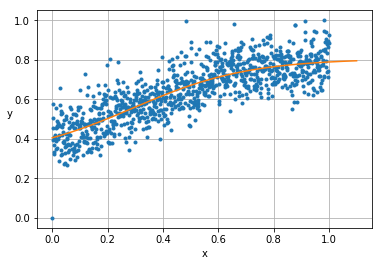

In [18]:
#https://stackoverflow.com/questions/4308168/sigmoidal-regression-with-scipy-numpy-python-etc

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

def sigmoid(p,x):
    x0,y0,c,k=p
    y = c / (1 + np.exp(-k*(x-x0))) + y0
    return y

def residuals(p,x,y):
    return y - sigmoid(p,x)

def resize(arr,lower=0.0,upper=1.0):
    arr=arr.copy()
    print("rescale back 1: +",arr.min(),"-",lower)
    if lower>upper: lower,upper=upper,lower
    arr -= arr.min()
    print("rescale back 2: *",1/((upper-lower)/arr.max()),"-",lower)
    arr *= (upper-lower)/arr.max()
    arr += lower
    return arr

# raw data

y = np.array(np.nan_to_num(my_data[:,1]),dtype='float')
x = np.array(np.arange(0,len(np.nan_to_num(my_data[:,1])))-time_UV,dtype='float')
#x = np.array([821,576,473,377,326],dtype='float')
#y = np.array([255,235,208,166,157],dtype='float')

x=resize(+x,lower=0.)
y=resize(y,lower=0.)
print(x)
print(y)
p_guess=(np.median(x),np.median(y),1.0,1.0)
p, cov, infodict, mesg, ier = scipy.optimize.leastsq(
    residuals,p_guess,args=(x,y),full_output=1)  

x0,y0,c,k=p
print('''\
x0 = {x0}
y0 = {y0}
c = {c}
k = {k}
'''.format(x0=x0,y0=y0,c=c,k=k))

xp = np.linspace(0, 1.1, 1500)
pxp=sigmoid(p,xp)

# Plot the results
plt.plot(x, y, '.', xp, pxp, '-')
plt.xlabel('x')
plt.ylabel('y',rotation='horizontal') 
plt.grid(True)
plt.show()

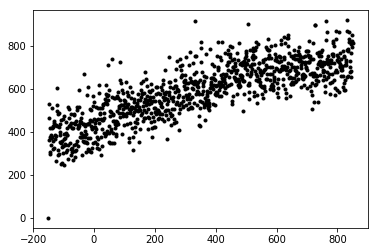

rescale back 1: + -150.0 - 0.0
rescale back 2: * 1000.0 - 0.0
rescale back 1: + 0.0 - 0.0
rescale back 2: * 919.555 - 0.0


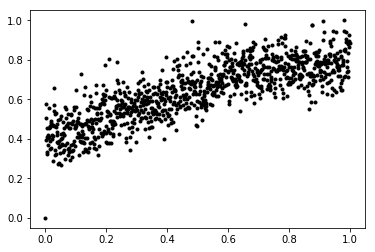

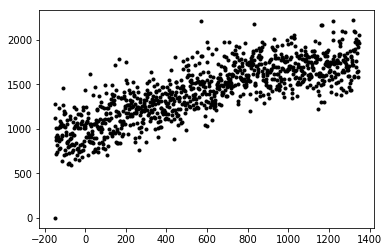

[ 0.29096     0.30559521  0.49970131  4.77042036]


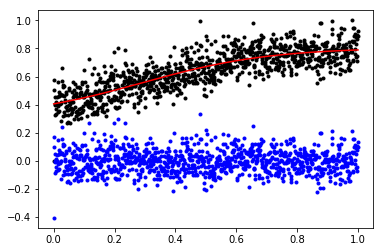

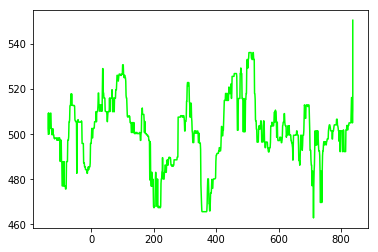

In [19]:
yt = np.array(np.nan_to_num(my_data[:,1]),dtype='float')
xt = np.array(np.arange(0,len(np.nan_to_num(my_data[:,1])))-time_UV,dtype='float')

plt.plot(xt, yt, 'k.')
plt.show()


xt=resize(+xt,lower=0.)
yt=resize(yt,lower=0.)
plt.plot(xt, yt, 'k.')

plt.show()
plt.plot(-150.0+xt*1498.0, 2217.347*yt, 'k.')
plt.show()

plt.plot(xt, yt, 'k.')
# np.linspace(start, stop, number of samples)
xxt = np.linspace(0, len(xt), len(xt))

print(p)

#x0,y,c,k
# adjust the y0 to fit the data
#p = [ 0.29096    ,0.12559521 , 0.49970131 , 4.77042036]
pxp=sigmoid(p,xt)
plt.plot(xt, pxp, 'r-')


plt.plot(xt, yt-pxp, 'b.')

yadjust = 500

plt.show()
#plt.plot(-150.0+xt*1498.0, 2217.347*(yt-pxp)+yadjust, 'b.')



finalx = -150.0+xt*1000
finaly = 919.555*(yt-pxp)+yadjust
plt.plot(scipy.ndimage.median_filter(finalx,size=50),scipy.ndimage.median_filter(finaly,size=50),c=c_ch2)
plt.show()







1001
1001


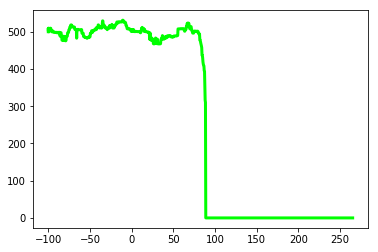

In [20]:
windowSize = 50


finalxClean = time_vesicle - time_UV + forceFileLeadTime + timeShiftDueDoWalkAvg
finalyClean= cleanTraceAfterScission(finaly,breakFrameId)
print(len(finalxClean))
print(len(finalyClean))
plt.plot(scipy.ndimage.median_filter(finalxClean,size=windowSize),
         scipy.ndimage.median_filter(finalyClean,size=windowSize),c=c_ch2,lw=3)

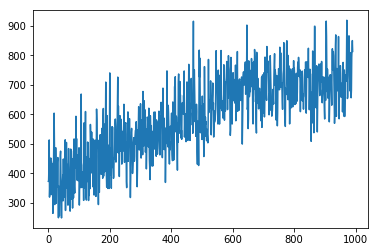

In [21]:
plt.plot(np.array(np.nan_to_num(my_data[10:,1]),dtype='float'))

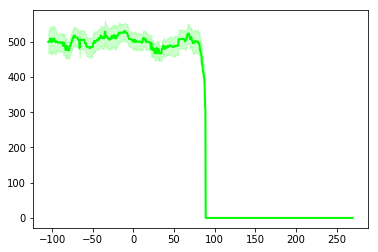

In [22]:
#calculate the standard deviation for the trace

mean = scipy.ndimage.median_filter(finalyClean,size=50)
std = scipy.ndimage.generic_filter(np.array(np.nan_to_num(my_data[:,1]),dtype='float'),np.std,size=50)
for i in range(0,len(mean)):
    if(mean[i]==0):
        std[i]=0
    else:
        std[i]=std[i]/mean[i]/3
        
# remove the artificial spike in standard deviation due to the cut        
#for i in range(0,len(mean)-50):
#    if(std[i+10]==0):
#        std[i]=0.2*std[i]
        
        
plt.plot(finalxClean,mean,c=c_ch2,lw=2)
#plt.plot(tube_intensity[:,0],std,c='blue',lw=2)
plt.fill_between(finalxClean,mean-1*std*mean, mean+1*std*mean, color=c_ch2, alpha=0.2)
plt.show()


#img_std = ndimage.filters.generic_filter(img, np.std, size=subs)

In [23]:




# output corrected intensity File
output_data_intensity = np.transpose(np.asarray((finalxClean,mean,std)))

writeOutputToFile("./output/out_vesicle_fluorescenceIntensity_ch2_corrected.csv",output_data_intensity,header="time[s], max intensity ch3[AU]")



# correct tube fluorescence ch2

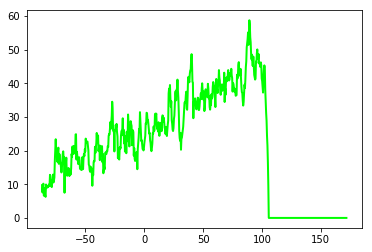

In [24]:
from numpy import genfromtxt


tube_intensity = genfromtxt('./output/out_tube_fluorescenceIntensity_raw.csv', delimiter=',')
plt.plot(tube_intensity[:,0],tube_intensity[:,2],c=c_ch2,lw=2)
plt.show()




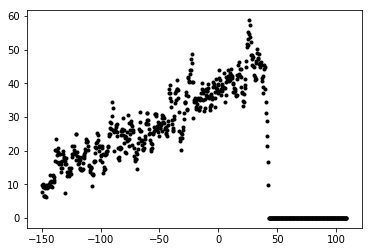

rescale back 1: + -149.6256 - 0.0
rescale back 2: * 258.336 - 0.0
rescale back 1: + 0.0 - 0.0
rescale back 2: * 58.70655 - 0.0


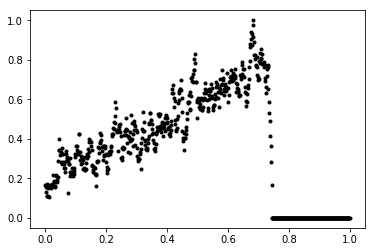

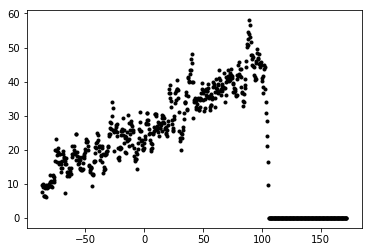

[ 0.29096     0.30559521  0.49970131  4.77042036]


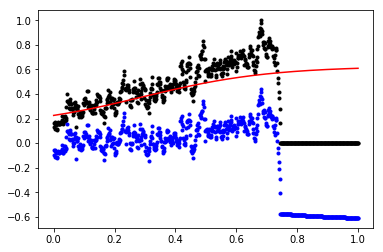

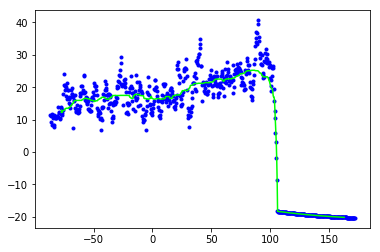

In [25]:
xt = time-time_UV
#yt = nonZeroedFilteredResults_ch2[:,2]
yt = tube_intensity[:,2]
plt.plot(xt, yt, 'k.')
plt.show()


xt=resize(+xt,lower=0.)
yt=resize(yt,lower=0.)
plt.plot(xt, yt, 'k.')

plt.show()
plt.plot(-86.6256+xt*258.336, 58*yt, 'k.')
plt.show()

plt.plot(xt, yt, 'k.')
# np.linspace(start, stop, number of samples)
xxt = np.linspace(0, len(xt), len(xt))

print(p)

#x0,y,c,k
# adjust the y0 to fit the data
p = [ 0.29096    ,0.12559521 , 0.49970131 , 4.77042036]
pxp=sigmoid(p,xt)
plt.plot(xt, pxp, 'r-')


plt.plot(xt, yt-pxp, 'b.')

plt.show()
plt.plot(-86.6256+xt*258.336, 58*(yt-pxp)+15, 'b.')


finalx = -86.6256+xt*258.336
finaly = 58*(yt-pxp)+15
plt.plot(scipy.ndimage.median_filter(finalx,size=100),scipy.ndimage.median_filter(finaly,size=100),c=c_ch2)
plt.show()






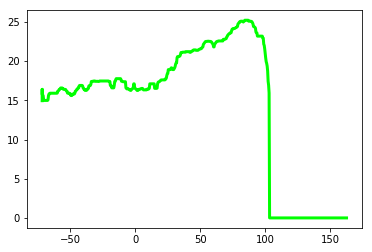

In [26]:
finalxClean = finalx[15:-1]
finalyClean= cleanTraceAfterScission(finaly,breakFrameId-10)[15:-1] # the -10 comes from the walkAvg10 that I used
plt.plot(scipy.ndimage.median_filter(finalxClean,size=100),
         scipy.ndimage.median_filter(finalyClean,size=100),c=c_ch2,lw=3)

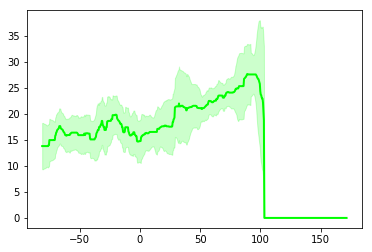

In [27]:
#calculate the standard deviation for the trace

# if I calculate the standard deviation from the tube values directly, I get almost zero standard deviation.
# but that is unrealistic. I take the standard deviation from the vesicle fluorescence instead.
# so the algorithm is now: take the max(std(vesicle),std(tube))

mean = scipy.ndimage.median_filter(finalyClean,size=50)
std = scipy.ndimage.generic_filter(tube_intensity[:,2][15:-1],np.std,size=50)
for i in range(0,len(mean)):
    if(mean[i]==0):
        std[i]=0
    else:
        std[i]=std[i]/mean[i]
        
# remove the artificial spike in standard deviation due to the cut        
for i in range(0,len(mean)-50):
    if(std[i+30]==0):
        std[i]=0.7*std[i]
        
        
plt.plot(finalxClean,mean,c=c_ch2,lw=2)
#plt.plot(tube_intensity[:,0],std,c='blue',lw=2)
plt.fill_between(finalxClean,mean-1*std*mean, mean+1*std*mean, color=c_ch2, alpha=0.2)
plt.show()


#img_std = ndimage.filters.generic_filter(img, np.std, size=subs)

In [28]:
# output corrected intensity File
output_data_intensity = np.transpose(np.asarray((finalxClean,mean,std)))

writeOutputToFile("./output/out_tube_fluorescenceIntensity_ch2_corrected.csv",output_data_intensity,header="time[s], max intensity ch2[AU],std")




# Correct Tube Fluorescence Channel 1

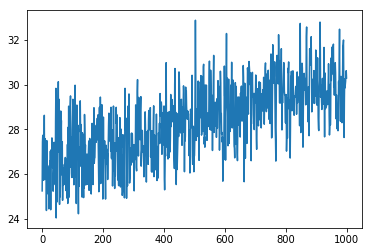

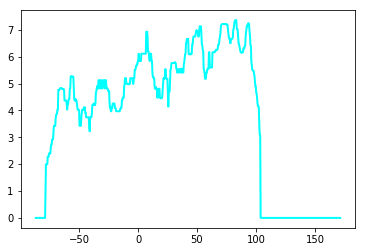

In [29]:
from numpy import genfromtxt
my_data = np.array(genfromtxt('./input/vesicle_tube_UV_movie__ch1_flPerFrame.csv', delimiter=','))
plt.plot(my_data[:,0],my_data[:,1],'-')
plt.show()

#idx1=158
idx1 = 0
idx2 = -1
tube_intensity = genfromtxt('./output/out_tube_fluorescenceIntensity_raw.csv', delimiter=',')
plt.plot(tube_intensity[:,0][idx1:idx2],scipy.ndimage.median_filter(np.abs(tube_intensity[:,1][idx1:idx2]),size=40),c=c_ch1,lw=2)
plt.show()

ch1_tubetime = tube_intensity[:,0][idx1:idx2]
ch1_tubeIntensity = tube_intensity[:,1][idx1:idx2]



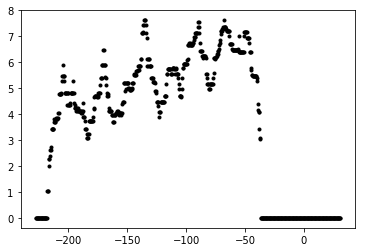

rescale back 1: + -227.6256 - 0.0
rescale back 2: * 258.336 - 0.0
rescale back 1: + 0.0 - 0.0
rescale back 2: * 7.61961 - 0.0


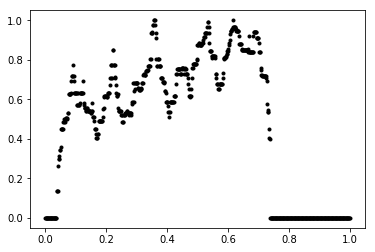

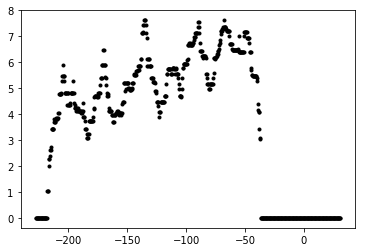

[0.29096, 0.12559521, 0.49970131, 4.77042036]


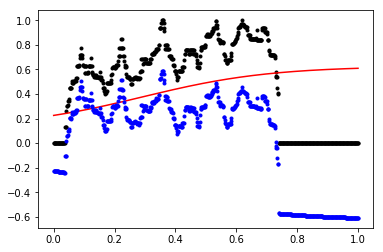

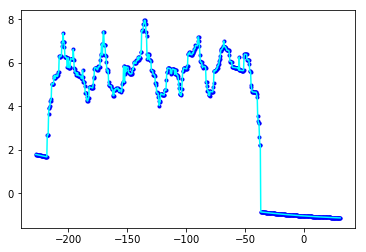

In [30]:
#time = np.array(np.arange(0,len(np.nan_to_num(my_data[:,1]))))
xt = tube_intensity[:,0]-timeShiftDueDoWalkAvg-time_UV
#yt = nonZeroedFilteredResults_ch2[:,2]
yt = scipy.ndimage.median_filter(np.abs(tube_intensity[:,1]),size=30)
plt.plot(xt, yt, 'k.')
plt.show()

a = -227.6256
b = 258.336
c = 7.61961

xt=resize(+xt,lower=0.)
yt=resize(yt,lower=0.)
plt.plot(xt, yt, 'k.')

plt.show()
plt.plot(a+xt*b, c*yt, 'k.')
plt.show()

plt.plot(xt, yt, 'k.')
# np.linspace(start, stop, number of samples)
xxt = np.linspace(0, len(xt), len(xt))

print(p)

#x0,y,c,k
# adjust the y0 to fit the data
p = [0.29096, 0.12559521, 0.49970131, 4.77042036]
pxp=sigmoid(p,xt)
plt.plot(xt, pxp, 'r-')


plt.plot(xt, yt-pxp, 'b.')

yadjust = 3.5

plt.show()
plt.plot(a+xt*b, c*(yt-pxp)+yadjust, 'b.')



finalx = a+xt*b
finaly = c*(yt-pxp)+yadjust
plt.plot(scipy.ndimage.median_filter(finalx,size=1),scipy.ndimage.median_filter(finaly,size=1),c=c_ch1)
plt.show()







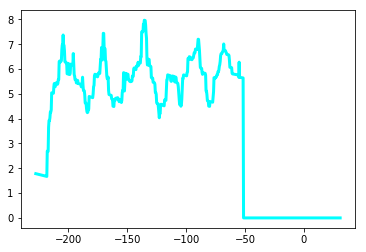

In [31]:
finalxClean = finalx
finalyClean= cleanTraceAfterScission(finaly,breakFrameId-45)
plt.plot(scipy.ndimage.median_filter(finalxClean,size=1),
         scipy.ndimage.median_filter(finalyClean,size=1),c=c_ch1,lw=3)

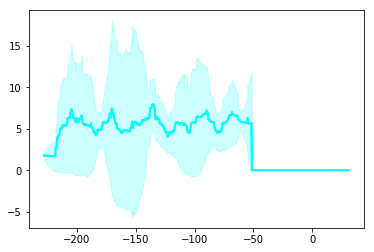

In [32]:
#mean = scipy.ndimage.median_filter(finalyClean,size=50)[0:688]
#std = scipy.ndimage.generic_filter(finaly,np.std,size=50)
#for i in range(0,len(mean)):
#    if(mean[i]==0):
#        std[i]=0
#    else:
#        std[i]=std[i]/mean[i]
#        
## remove the artificial spike in standard deviation due to the cut        
#for i in range(0,len(mean)-50):
#    if(std[i+30]==0):
#        std[i]=0.2*std[i]
#        
        



tube_intensity = genfromtxt('./output/out_tube_fluorescenceIntensity.csv', delimiter=',')
mean = finalyClean 
std = scipy.ndimage.generic_filter(tube_intensity[:,1],np.std,size=100)#[0:690]
for i in range(0,len(mean)):
    if(mean[i]==0):
        std[i]=0
        
        # remove the artificial spike in standard deviation due to the cut        
for i in range(0,len(mean)-50):
    if(std[i+30]==0):
        std[i]=0.5*std[i]


plt.plot(finalxClean,mean,c=c_ch1,lw=2)
plt.plot(finalxClean,mean,c=c_ch1,lw=2)
#plt.plot(tube_intensity[:,0],std,c='blue',lw=2)
plt.fill_between(finalxClean,mean-1*std*mean, mean+1*std*mean, color=c_ch1, alpha=0.2)
plt.show()



In [33]:
# output corrected intensity File
output_data_intensity = np.transpose(np.asarray((finalxClean,finalyClean,std)))

writeOutputToFile("./output/out_tube_fluorescenceIntensity_ch1_corrected.csv",output_data_intensity,header="time[s], max intensity ch1[AU],max intensity ch1[AU], std")






# Correct vesicle intensity file

rescale back 1: + -150.0 - 0.0
rescale back 2: * 1000.0 - 0.0
rescale back 1: + 0.0 - 0.0
rescale back 2: * 32.88439 - 0.0
[ 0.     0.001  0.002 ...,  0.998  0.999  1.   ]
[ 0.          0.76756145  0.8341438  ...,  0.92850772  0.93127742
  0.9213934 ]
x0 = 0.29093221278111403
y0 = 0.7271210098430753
c = 0.21566843292302082
k = 2.661756792245381



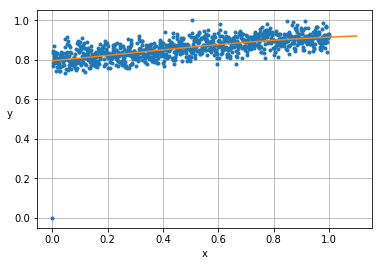

In [34]:
#https://stackoverflow.com/questions/4308168/sigmoidal-regression-with-scipy-numpy-python-etc

import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

def sigmoid(p,x):
    x0,y0,c,k=p
    y = c / (1 + np.exp(-k*(x-x0))) + y0
    return y

def residuals(p,x,y):
    return y - sigmoid(p,x)

def resize(arr,lower=0.0,upper=1.0):
    arr=arr.copy()
    print("rescale back 1: +",arr.min(),"-",lower)
    if lower>upper: lower,upper=upper,lower
    arr -= arr.min()
    print("rescale back 2: *",1/((upper-lower)/arr.max()),"-",lower)
    arr *= (upper-lower)/arr.max()
    arr += lower
    return arr

# raw data

y = np.array(np.nan_to_num(my_data[:,1]),dtype='float')
x = np.array(np.arange(0,len(np.nan_to_num(my_data[:,1])))-time_UV,dtype='float')
#x = np.array([821,576,473,377,326],dtype='float')
#y = np.array([255,235,208,166,157],dtype='float')

x=resize(+x,lower=0.)
y=resize(y,lower=0.)
print(x)
print(y)
p_guess=(np.median(x),np.median(y),1.0,1.0)
p, cov, infodict, mesg, ier = scipy.optimize.leastsq(
    residuals,p_guess,args=(x,y),full_output=1)  

x0,y0,c,k=p
print('''\
x0 = {x0}
y0 = {y0}
c = {c}
k = {k}
'''.format(x0=x0,y0=y0,c=c,k=k))

xp = np.linspace(0, 1.1, 1500)
pxp=sigmoid(p,xp)

# Plot the results
plt.plot(x, y, '.', xp, pxp, '-')
plt.xlabel('x')
plt.ylabel('y',rotation='horizontal') 
plt.grid(True)
plt.show()

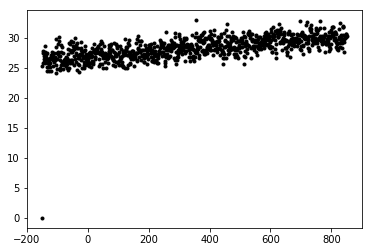

rescale back 1: + -150.0 - 0.0
rescale back 2: * 1000.0 - 0.0
rescale back 1: + 0.0 - 0.0
rescale back 2: * 32.88439 - 0.0


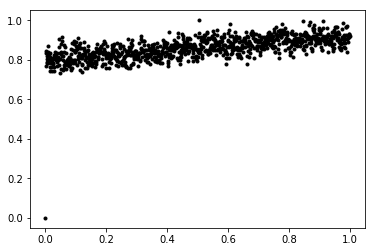

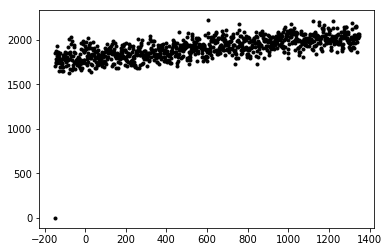

[ 0.29093221  0.72712101  0.21566843  2.66175679]


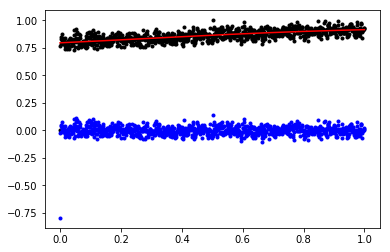

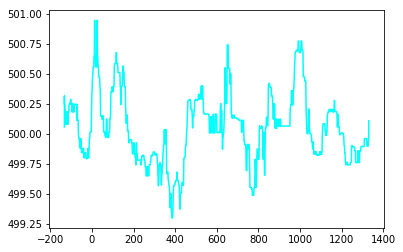

In [35]:
yt = np.array(np.nan_to_num(my_data[:,1]),dtype='float')
xt = np.array(np.arange(0,len(np.nan_to_num(my_data[:,1])))-time_UV,dtype='float')

plt.plot(xt, yt, 'k.')
plt.show()


xt=resize(+xt,lower=0.)
yt=resize(yt,lower=0.)
plt.plot(xt, yt, 'k.')

plt.show()
plt.plot(-150.0+xt*1498.0, 2217.347*yt, 'k.')
plt.show()

plt.plot(xt, yt, 'k.')
# np.linspace(start, stop, number of samples)
xxt = np.linspace(0, len(xt), len(xt))

print(p)

#x0,y,c,k
# adjust the y0 to fit the data
#p = [ 0.29096    ,0.12559521 , 0.49970131 , 4.77042036]
pxp=sigmoid(p,xt)
plt.plot(xt, pxp, 'r-')


plt.plot(xt, yt-pxp, 'b.')

yadjust = 500

plt.show()
#plt.plot(-150.0+xt*1498.0, 2217.347*(yt-pxp)+yadjust, 'b.')



finalx = -150.0+xt*1498.0
finaly = 39.3962*(yt-pxp)+yadjust
plt.plot(scipy.ndimage.median_filter(finalx,size=50),scipy.ndimage.median_filter(finaly,size=50),c=c_ch1)
plt.show()








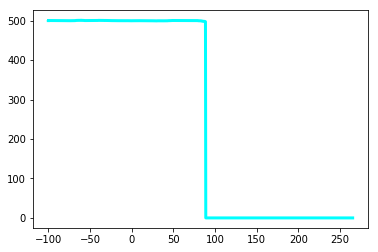

In [36]:
windowSize = 50

finalxClean = time_vesicle - time_UV + forceFileLeadTime + timeShiftDueDoWalkAvg
finalyClean= cleanTraceAfterScission(finaly,breakFrameId)

plt.plot(scipy.ndimage.median_filter(finalxClean,size=windowSize),
         scipy.ndimage.median_filter(finalyClean,size=windowSize),c=c_ch1,lw=3)

In [37]:
print(len(finalxClean))

1001


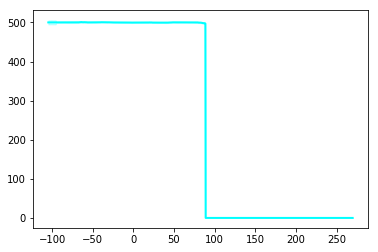

In [38]:
#calculate the standard deviation for the trace

mean = scipy.ndimage.median_filter(finalyClean,size=50)
std = scipy.ndimage.generic_filter(np.array(np.nan_to_num(my_data[:,1]),dtype='float'),np.std,size=50)
for i in range(0,len(mean)):
    if(mean[i]==0):
        std[i]=0
    else:
        std[i]=std[i]/mean[i]
        
# remove the artificial spike in standard deviation due to the cut        
#for i in range(0,len(mean)-50):
#    if(std[i+10]==0):
#        std[i]=0.2*std[i]
        
        
plt.plot(finalxClean,mean,c=c_ch1,lw=2)
#plt.plot(tube_intensity[:,0],std,c='blue',lw=2)
plt.fill_between(finalxClean,mean-1*std*mean, mean+1*std*mean, color=c_ch1, alpha=0.2)
plt.show()


#img_std = ndimage.filters.generic_filter(img, np.std, size=subs)

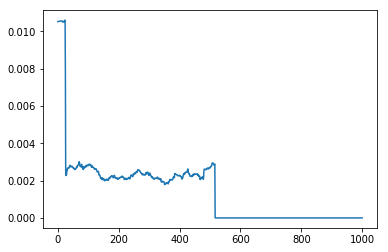

In [39]:
plt.plot(std)

In [40]:
# output corrected intensity File
output_data_intensity = np.transpose(np.asarray((finalxClean,finalyClean,std)))

writeOutputToFile("./output/out_vesicle_fluorescenceIntensity_ch1_corrected.csv",output_data_intensity,header="time[s], max intensity[AU], std")





